In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [16]:
#export
from exp.nb_04 import *
import pdb

## Initial Setup

In [3]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [4]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [5]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [6]:
learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.680020546875, tensor(0.7971)]
valid: [0.3062982177734375, tensor(0.9109)]
train: [0.2979840234375, tensor(0.9132)]
valid: [0.272037060546875, tensor(0.9187)]
train: [0.23857630859375, tensor(0.9314)]
valid: [0.2046646728515625, tensor(0.9426)]


In [7]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.7573875, tensor(0.7959)]
valid: [0.346579541015625, tensor(0.9045)]
train: [0.3491723828125, tensor(0.8998)]
valid: [0.2909485595703125, tensor(0.9200)]
train: [0.29726720703125, tensor(0.9135)]
valid: [0.2572588134765625, tensor(0.9277)]


In [8]:
#export
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

## Annealing

In [115]:
class ParamScheduler(Callback):
    _order = 1
    def __init__(self, pname, sched_func):
        self.pname, self.sched_func = pname,sched_func
    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
    def begin_batch(self):
        if self.in_train: self.set_param()

In [126]:
class Recorder(Callback):
    def begin_fit(self):
        self.lrs,self.losses = [],[]
    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.learn.opt.param_groups[-1]['lr'])
        #pdb.set_trace()
        self.losses.append(self.loss.detach().cpu())
    def plot_lr(self):
        plt.plot(self.lrs)
    def plot_losses(self):
        plt.plot(self.losses)

In [127]:
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos*(end-start)
    return partial(_inner, start, end)

In [128]:
f = sched_lin(0.3, 0.7)

In [129]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', f)]

In [130]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [131]:
run.fit(10,learn)

train: [0.763658203125, tensor(0.8010)]
valid: [0.393790478515625, tensor(0.8859)]
train: [0.3423898828125, tensor(0.9013)]
valid: [0.2730533203125, tensor(0.9228)]
train: [0.28127609375, tensor(0.9197)]
valid: [0.249937255859375, tensor(0.9288)]
train: [0.243846796875, tensor(0.9301)]
valid: [0.2331022705078125, tensor(0.9328)]
train: [0.21335509765625, tensor(0.9389)]
valid: [0.1920261474609375, tensor(0.9449)]
train: [0.18956291015625, tensor(0.9451)]
valid: [0.19466611328125, tensor(0.9425)]
train: [0.16989974609375, tensor(0.9516)]
valid: [0.1596115966796875, tensor(0.9555)]
train: [0.14781923828125, tensor(0.9572)]
valid: [0.14706651611328125, tensor(0.9567)]
train: [0.13723951171875, tensor(0.9609)]
valid: [0.1364104248046875, tensor(0.9616)]
train: [0.122321943359375, tensor(0.9643)]
valid: [0.15236392822265624, tensor(0.9538)]


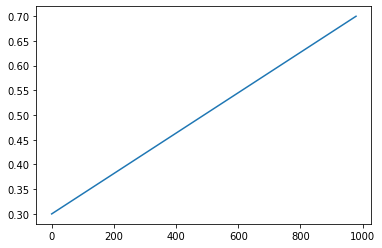

In [132]:
run.recorder.plot_lr()

In [133]:
#export
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

In [134]:
#export
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

In [135]:
torch.cumsum??

In [136]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [137]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

In [138]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [143]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [144]:
run.fit(10, learn)

train: [0.76898546875, tensor(0.8036)]
valid: [0.3477662353515625, tensor(0.8999)]
train: [0.3480853515625, tensor(0.8986)]
valid: [0.2713793701171875, tensor(0.9241)]
train: [0.2815472265625, tensor(0.9174)]
valid: [0.2240536865234375, tensor(0.9375)]
train: [0.21557365234375, tensor(0.9381)]
valid: [0.2153896728515625, tensor(0.9370)]
train: [0.18161154296875, tensor(0.9478)]
valid: [0.1697625244140625, tensor(0.9531)]
train: [0.15775943359375, tensor(0.9551)]
valid: [0.1473133056640625, tensor(0.9597)]
train: [0.141992451171875, tensor(0.9598)]
valid: [0.1397441162109375, tensor(0.9621)]
train: [0.1320327734375, tensor(0.9628)]
valid: [0.13386092529296875, tensor(0.9622)]
train: [0.1240848828125, tensor(0.9652)]
valid: [0.1324443603515625, tensor(0.9640)]
train: [0.1189673828125, tensor(0.9664)]
valid: [0.1271045166015625, tensor(0.9642)]


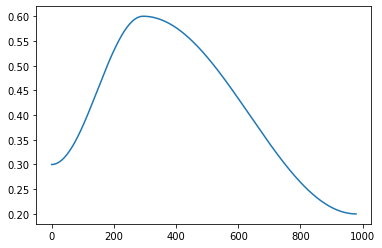

In [145]:
run.recorder.plot_lr()

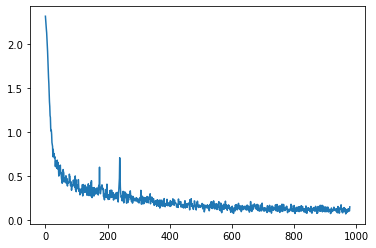

In [146]:
run.recorder.plot_losses()